# TRABAJO PRÁCTICO Nº 6

**Alumnos:**
- Nahuel Arrieta
- Lucas moyano

In [18]:
import sys
from skimage import io, color, measure
from skimage.color import label2rgb
from skimage.morphology import closing, footprint_rectangle
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def read_image(image_name):
    image_path = "./images/" + image_name

    # Read the image
    image = io.imread(image_path)   
    return image

In [4]:
def show_image(label, image):
  ## Create a plot
  plt.imshow(image, cmap='gray')
  plt.title(label)
  plt.axis('off')
  plt.show()

## Sección 1: Representaci´on y Descripci´on de Caracter´ısticas

### 2. (*) Representaci´on por relleno de regiones. Identificar los objetos en una imagen binaria y colorear cada regi´on detectada. Sugerencia: scikit-image: measure.label, regionprops, label2rgb.

In [21]:
## Apply the Otsu thresholding method
def apply_otsu_threshold(image):
    # Convert to grayscale if the image is RGB
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    
    # Apply Otsu's threshold
    thresh = threshold_otsu(image)
    binary = image > thresh
    
    return binary



In [22]:
def plot_regions(binary_image, colored_regions):
    """Muestra la imagen binaria original y las regiones coloreadas."""
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Imagen Binaria")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colored_regions)
    plt.title("Regiones Coloreadas")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

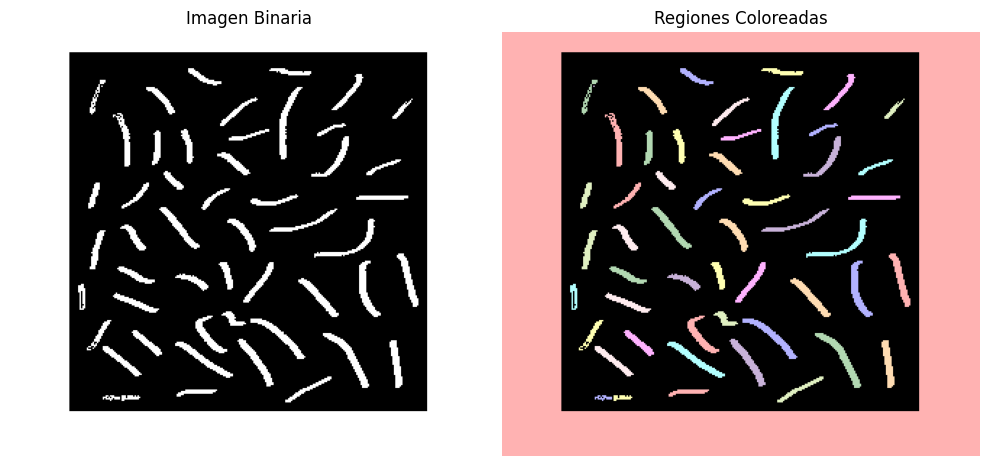

In [23]:
image = read_image("binary.png")
binary_image = apply_otsu_threshold(image)
label_image = measure.label(binary_image)
colored = label2rgb(label_image, image=binary_image, bg_label=0)
plot_regions(binary_image, colored)


### 4. (*) C´alculo de propiedades geom´etricas. Extraer ´area, per´ımetro, excentricidad y compacidad de cada regi´on segmentada. Sugerencia: regionprops de skimage.measure.

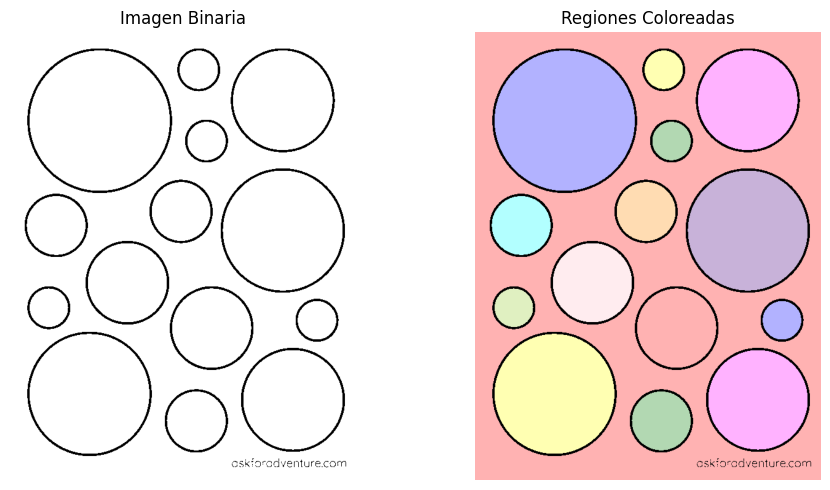

Región 1: Area=187418.0, Perimeter=9535.681092190353, Eccentricity=0.64, Compactness=485.17
Región 2: Area=40881.0, Perimeter=753.3523804664972, Eccentricity=0.03, Compactness=13.88
Región 3: Area=3067.0, Perimeter=203.8233764908628, Eccentricity=0.09, Compactness=13.55
Región 4: Area=20596.0, Perimeter=533.8721497261419, Eccentricity=0.04, Compactness=13.84
Región 5: Area=3066.0, Perimeter=203.8233764908628, Eccentricity=0.09, Compactness=13.55
Región 6: Area=29861.0, Perimeter=643.0264786586926, Eccentricity=0.05, Compactness=13.85
Región 7: Area=7182.0, Perimeter=314.14927829866735, Eccentricity=0.07, Compactness=13.74
Región 8: Area=7181.0, Perimeter=314.3919189857867, Eccentricity=0.05, Compactness=13.76
Región 9: Area=13007.0, Perimeter=422.47518010647184, Eccentricity=0.03, Compactness=13.72
Región 10: Area=3065.0, Perimeter=205.23759005323595, Eccentricity=0.07, Compactness=13.74
Región 11: Area=13017.0, Perimeter=424.71782079359116, Eccentricity=0.04, Compactness=13.86
Región 

In [24]:
image = read_image("circles.png")
binary_image = apply_otsu_threshold(image)
label_image = measure.label(binary_image)
colored = label2rgb(label_image, image=binary_image, bg_label=0)
plot_regions(binary_image, colored)

props = measure.regionprops(label_image)
for prop in props:
    area = prop.area
    perimeter = prop.perimeter
    eccentricity = prop.eccentricity
    compactness = (perimeter ** 2) / area if area > 0 else 0    
    
    print(f"Región {prop.label}: Area={area}, Perimeter={perimeter}, Eccentricity={eccentricity:.2f}, Compactness={compactness:.2f}")


### 6. (*) Descriptores de textura con GLCM. Calcular contraste, correlaci´on y homogeneidad de regiones usando matrices de co-ocurrencia. skimage.feature.greycomatrix, greycoprops.


In [25]:
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte

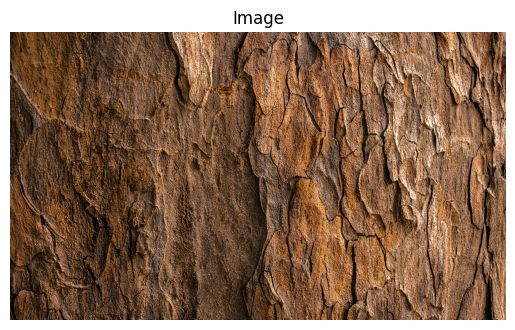

Contrast:     17806.4886
Correlation:  0.4394
Homogeneity:  0.7262


In [26]:
image = read_image("wood.png")
show_image("Image", image)
image = apply_otsu_threshold(image)
# Convert image to uint8
image_uint8 = img_as_ubyte(image)

# Compute the Gray-Level Co-occurrence Matrix (GLCM)
glcm = graycomatrix(image_uint8, 
                    distances=[1], 
                    angles=[0], 
                    levels=256,
                    symmetric=True, 
                    normed=True)

# Extract texture properties
contrast = graycoprops(glcm, 'contrast')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

# Print results
print(f"Contrast:     {contrast:.4f}")
print(f"Correlation:  {correlation:.4f}")
print(f"Homogeneity:  {homogeneity:.4f}")


### 8. (*) Relaci´on espacial entre regiones. Determinar si las regiones est´an adyacentes o si una est´a contenida en otra. skimage.measure.regionprops + an´alisis de coordenadas / bounding boxes.

In [27]:
from scipy.ndimage import binary_dilation


In [28]:
def check_containment(bbox1, bbox2):
    """Check if bbox2 is fully contained within bbox1."""
    return (bbox2[0] >= bbox1[0] and bbox2[1] >= bbox1[1] and
            bbox2[2] <= bbox1[2] and bbox2[3] <= bbox1[3])


In [29]:
def get_full_mask(region, image_shape):
    """Return a binary mask of the full image shape with the region placed correctly."""
    full_mask = np.zeros(image_shape, dtype=bool)
    minr, minc, maxr, maxc = region.bbox
    full_mask[minr:maxr, minc:maxc] = region.image
    return full_mask

def check_adjacency(mask1, mask2):
    """Check if two regions are adjacent using morphological dilation."""
    # Determine the maximum shape for padding
    max_rows = max(mask1.shape[0], mask2.shape[0])
    max_cols = max(mask1.shape[1], mask2.shape[1])

    # Pad both masks to the same shape
    padded_mask1 = np.zeros((max_rows, max_cols), dtype=bool)
    padded_mask2 = np.zeros((max_rows, max_cols), dtype=bool)

    padded_mask1[:mask1.shape[0], :mask1.shape[1]] = mask1
    padded_mask2[:mask2.shape[0], :mask2.shape[1]] = mask2

    # Dilate the first padded mask
    dilation_structure = np.ones((10, 10), dtype=bool)  # 3x3 square structuring element
    dilated1 = binary_dilation(padded_mask1, structure=dilation_structure)

    # Check for adjacency
    return np.any(dilated1 & padded_mask2)


Region 1 is adjacent to Region 2
Region 1 contains Region 6
Region 1 is adjacent to Region 7
Region 2 contains Region 4
Region 2 is adjacent to Region 7


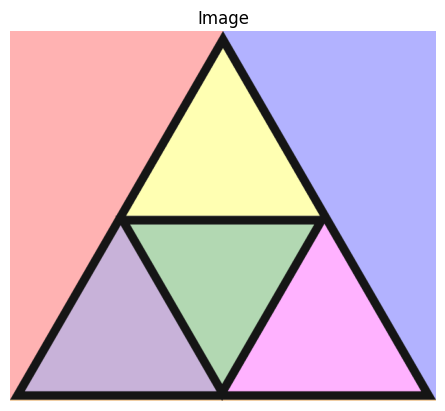

In [31]:
image = read_image("triangles.png")
binary_image = apply_otsu_threshold(image)

label_image = measure.label(binary_image)
props = measure.regionprops(label_image)

image_shape = image.shape[:2]
    

for i, prop1 in enumerate(props):
    for j, prop2 in enumerate(props):
        if i >= j:
            continue
        
        bbox1 = prop1.bbox
        bbox2 = prop2.bbox

        mask1 = get_full_mask(prop1, image_shape)
        mask2 = get_full_mask(prop2, image_shape)
        
        if check_containment(bbox1, bbox2):
            print(f"Region {prop1.label} contains Region {prop2.label}")
        elif check_containment(bbox2, bbox1):
            print(f"Region {prop2.label} contains Region {prop1.label}")

        elif check_adjacency(mask1, mask2):
            print(f"Region {prop1.label} is adjacent to Region {prop2.label}")

# Show the labeled image
show_image("Image", label2rgb(label_image, image=image, bg_label=0))


## Sección 2: Reconocimiento de Patrones

In [2]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import layers
from keras import models
import matplotlib.pyplot as plt

import cv2
import numpy as np

### 1. (*) Template Matching. Buscar una figura conocida dentro de una imagen mediante una plantilla. Sugerencia: cv2.matchTemplate, cv2.minMaxLoc.

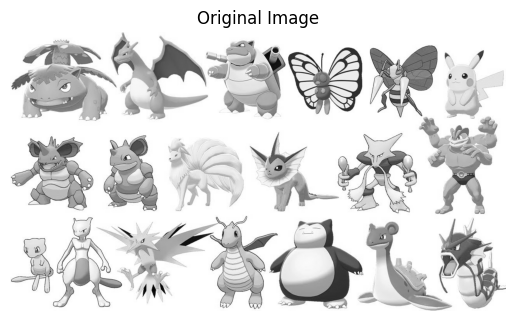

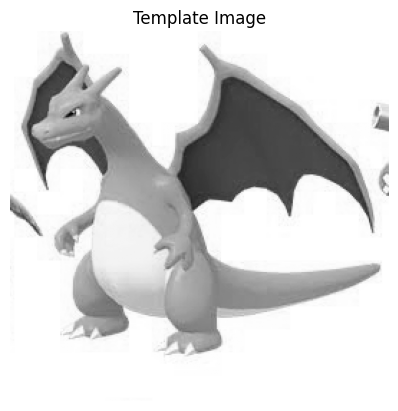

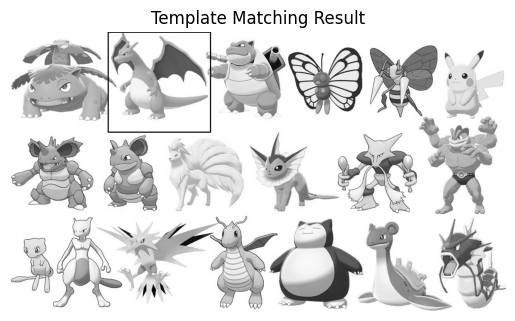

In [9]:
image = cv2.imread('images/pokemones.jpg', 0)
template = cv2.imread('images/charmander.png', 0)

show_image("Original Image", image)
show_image("Template Image", template)

result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

top_left = max_loc
h, w = template.shape
bottom_right = (top_left[0] + w, top_left[1] + h)

# Draw rectangle (use a copy to avoid modifying the original)
image_rect = image.copy()
cv2.rectangle(image_rect, top_left, bottom_right, 0, 2)

plt.imshow(image_rect, cmap='gray')
plt.title('Template Matching Result')
plt.axis('off')
plt.show()

### 2. (*) Clasificación basada en características. Extraer características simples (como área o textura) de regiones segmentadas y clasificarlas usando KNN. Sugerencia: scikit-learn + descriptores de regionprops.

In [2]:
from skimage import io, filters, measure, color, morphology
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops_table
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

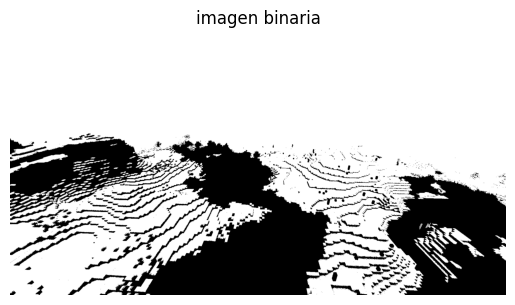

In [6]:
# Cargar imagen en escala de grises
image = io.imread('images/minecraftBiomes.jpg', as_gray=True)

# Umbral simple para binarizar
binary = image > filters.threshold_otsu(image)

# Limpiar ruido
binary = morphology.remove_small_objects(binary, min_size=50)
show_image("imagen binaria", binary)
# Etiquetar regiones conectadas
label_image = measure.label(binary)

In [8]:


# Extraer características
props = regionprops_table(label_image, intensity_image=image, 
                          properties=['area', 'eccentricity', 'mean_intensity'])
# Convertir a DataFrame para fácil manejo
df = pd.DataFrame(props)
print(df)

# (Opcional) Agregar etiquetas manuales (en práctica real: con anotaciones)
# Aquí simulamos etiquetas (por ejemplo, 0 y 1)
df['label'] = np.random.choice([0, 1], size=len(df))  # Solo ejemplo

          area  eccentricity  mean_intensity
0    1322894.0      0.875322        0.786932
1         71.0      0.991728        0.708869
2       3450.0      0.996376        0.791087
3        172.0      0.959734        0.865761
4         75.0      0.853391        0.895655
..         ...           ...             ...
102      647.0      0.822111        0.874195
103      577.0      0.975424        0.715114
104       94.0      0.877794        0.689390
105       85.0      0.907532        0.670073
106       69.0      0.950286        0.700796

[107 rows x 3 columns]


In [ ]:


# Separar features y etiquetas
X = df[['area', 'eccentricity', 'mean_intensity']]
y = df['label']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar clasificador KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predecir
y_pred = knn.predict(X_test)

# Evaluar
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

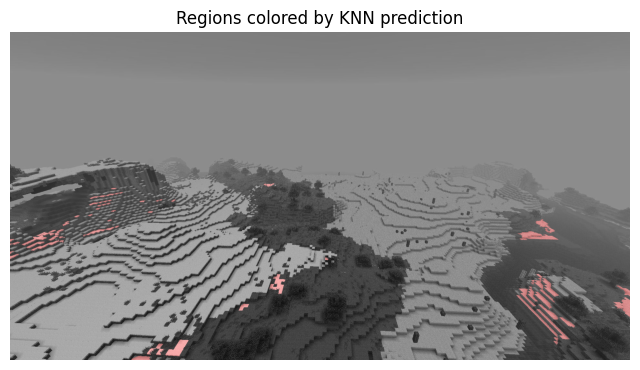

In [ ]:
import matplotlib.pyplot as plt
from skimage.color import label2rgb

# First, re-run predictions on all regions (not just test set) if needed
X_all = df[['area', 'eccentricity', 'mean_intensity']]
y_all_pred = knn.predict(X_all)

# Create a color image using predicted labels
# We'll map each label in `label_image` to its predicted class
label_colored = np.zeros_like(label_image, dtype=np.uint8)

# For each region, fill in pixels with predicted class label
for region_label, predicted_class in zip(df.index + 1, y_all_pred):
    label_colored[label_image == region_label] = predicted_class

# Overlay on grayscale image for context
overlay = label2rgb(label_colored, image=image, kind='overlay')

# Show result
plt.figure(figsize=(8, 6))
plt.title('Regions colored by KNN prediction')
plt.imshow(overlay)
plt.axis('off')
plt.show()


### 5. (*) Reconocimiento estructural. Representar caracteres como grafos de l´ıneas y nodos. Clasificarlos seg´un su estructura. Sugerencia: Estructuras de grafos con networkx (librer´ıa de python).

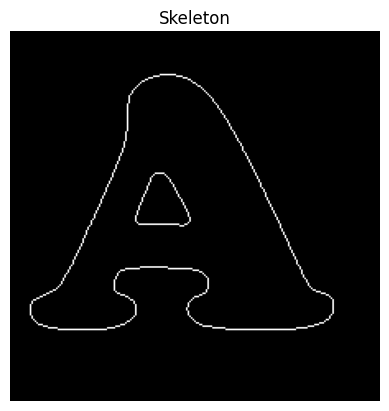

In [18]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
from skimage import io

# Cargar imagen en escala de grises
img = cv2.imread('images/letraA.png', 0)

# Binarizar
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# Skeletonize (reducir a líneas 1px)
skeleton = skeletonize(binary // 255)

# Mostrar resultado
import matplotlib.pyplot as plt
plt.imshow(skeleton, cmap='gray')
plt.title("Skeleton")
plt.axis('off')
plt.show()


In [19]:
import networkx as nx

def skeleton_to_graph(skel):
    G = nx.Graph()
    rows, cols = skel.shape
    for y in range(1, rows - 1):
        for x in range(1, cols - 1):
            if skel[y, x]:
                # Ver vecinos
                neighbors = [(j, i) for j in range(y - 1, y + 2)
                                     for i in range(x - 1, x + 2)
                                     if (i, j) != (x, y) and skel[j, i]]
                G.add_node((x, y))
                for n in neighbors:
                    G.add_edge((x, y), n)
    return G

G = skeleton_to_graph(skeleton)


In [20]:
print("Número de nodos:", G.number_of_nodes())
print("Número de aristas:", G.number_of_edges())

# Ejemplo: nodos de grado 1 = extremos, grado 3+ = intersecciones
degree_count = dict(nx.degree(G))
endpoints = [n for n, d in degree_count.items() if d == 1]
junctions = [n for n, d in degree_count.items() if d >= 3]

print("Extremos:", len(endpoints))
print("Intersecciones:", len(junctions))


Número de nodos: 1361
Número de aristas: 1371
Extremos: 0
Intersecciones: 16


### 6. (*) Clasificación con CNN (Deep Learning). Construir una red neuronal convolucional para clasificar dígitos (MNIST o similar). Sugerencia: TensorFlow o PyTorch + torchvision.datasets.MNIST.

In [ ]:


(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Cambiamos el tensor a un tensor de grado 4 (la ultima posición representa el numero de canales de colores en este caso 1) y normalizamos los valores
print(x_train.shape)
x_train = x_train.reshape((-1, 28, 28,1))
x_train = x_train.astype('float32') / 255
print(x_train.shape)
x_test = x_test.reshape((-1, 28, 28,1))
x_test = x_test.astype('float32') / 255# Hacemos one hot encoding a los labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)# Seteamos los parametros del modelo
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.fit(x_train, y_train, epochs=5, batch_size= 64)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(60000, 28, 28)
(60000, 28, 28, 1)


c:\Users\Lucas Estudio\Documents\Universidad\2025 1er semestre\Procesamiento de Imagenes\tps\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 69ms/step - accuracy: 0.8721 - loss: 0.4027
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.9847 - loss: 0.0508
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.9899 - loss: 0.0318
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.9927 - loss: 0.0221
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.9944 - loss: 0.0183
